# Q&A Accuracy with Golden Datasets

## Introduction

For many LLM use cases, an ability to provide accurate information is paramount. LLMs are susceptible to generating plausible but factually incorrect information, colloquially known as "hallucination". While system designs such as [Retrieval Augmented Generation](https://aws.amazon.com/what-is/retrieval-augmented-generation/) (RAG) help mitigate the risk of hallucination, RAG systems come with their own potential failure points, such as errors during retrieval from a knowledgebase or errors in the knowledgebase itself.

LLM applications which generate incorrect information can pose significant risks. For instance, a sales chatbot that provides incorrect information about products can lead to poor customer experiences, reputational damage, and even legal liability. Thus, rigorous testing and evaluation is critical to ensuring systems reliably produce accurate responses to user queries. 

This notebook focuses on testing and evaluating the accuracy of a Q&A chatbot using a "golden dataset" — validated correct answers to a set of standard questions. We will set up a fictional Q&A chatbot and demonstrate how to:

- **Create a golden dataset**: Use LLMs to assist in developing a benchmark dataset of golden questions and answers.
- **Create challenges by augmenting golden questions**: Leverage LLM augmentors to systematically generate diverse and challenging variants of the golden questions to test chatbot accuracy and robustness to different user inputs.
- **Validate evaluators**: Use LLMs to assist in creating a Q&A validation dataset for assessing performance of LLM evaluators, with "accuracy" comprised of 3 metrics: 
    - *Faithfulness*: Is the response consistent with all parts of the golden answer?
    - *Completeness*: Does the response cover all the key information in the golden answer?
    - *Relevance*: Are all parts of the response relevant to the question?
- **Run pipeline**: Run the testing and evaluation pipeline to get insights into the chatbot's performance.

New users should start with the ARTKIT setup guide on the documentation [Home page](../../../_generated/home.rst#installation) and the introductory tutorial [Building Your First ARTKIT Pipeline](../../../user_guide/introduction_to_artkit/building_your_first_artkit_pipeline.ipynb). 

## Setup

This notebook uses several libraries which are not part of the standard ARTKIT environment. You can install them with pip:

`pip install matplotlib seaborn`

Below, we import the required libraries, load environment variables, set the logging level to WARNING, and configure `pandas` to display dataframes with wide columns (this is helpful for displaying long strings).

In [1]:
import json
import logging

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import artkit.api as ak

# Load API keys from .env
load_dotenv()

# Set logger level to WARNING
logging.basicConfig(level=logging.WARNING)

# Display full text in pandas dataframe cells
pd.set_option("display.max_colwidth", None)

Next we initialize a session with OpenAI's GPT-4, which we will use for all LLM steps in this tutorial.

In [2]:
# Initialize an OpenAI chat model with caching
gpt4_chat = ak.CachedChatModel(
    model=ak.OpenAIChat(
        api_key_env="OPENAI_API_KEY",
        model_id="gpt-4o",
        temperature=0,
    ), 
    database="cache/qna_accuracy.db"
)

## Target System: SwiftPost Q&A

This section introduces a simple Q&A chatbot called Swifty, which interacts with customers of a fictional shipping company called SwiftPost. Swifty is programmed to answer customer questions about a specific SwiftPost offering called "Express Delivery Service".

Here are the details of Express Delivery Service which Swifty will reference in its answers:

In [3]:
EXPRESS_DELIVERY_SERVICE_CONTEXT = """\
# SwiftPost Express Delivery Service

General Information
- It is a premium service that ensures faster delivery of packages
- The main benefit is that it ensures faster delivery of packages
- It offers domestic shipping within the United States, excluding Hawaii and Alaska
- It does not offer international shipping

Weight and Size Restrictions
- We accommodate packages up to 30 kg in weight and 150 cm in combined length and width

Pricing by Package Weight
- If weight is less than 1 kg: Shipping price is $5
- If weight is within 1-5 kg: Shipping price is $15
- If weight is greater than 5 kg: Shipping price is $25

Add-ons (extra fees)
- Signature confirmation: $5
- Insurance: 1% of the value of the goods

Advanced Tracking System
- Free for all Express Delivery customers
- Each package is assigned a unique tracking number
- Real-time updates are available via our website, mobile app, or SMS

Packing Guidelines
- Comply with size and weight restrictions
- Use a sturdy, corrugated box secured with strong packing tape
- Provide internal cushioning with bubble wrap or foam peanuts
- Distribute contents evenly
- Clearly label fragile items
- Non-compliance with packing guidelines that necessitates repacking will result in \
a charge of $10

Next-Day Guarantee
- All domestic shipments are guaranteed to be delivered by the next business day
- If a package is delivered late, contact customer support to request a refund

Customer Service
- Phone number: 1-800-123-4567
- Email: CustomerSupport@SwiftPost.com\
"""

Next, we incorporate the context above into a general system prompt which instructs Swifty on how it should interact with customers and leverage the information in the context appropriately:

In [4]:
SWIFTY_SYSTEM_PROMPT = f"""\
You are Swifty, a customer service chatbot for SwiftPost, a fictional shipping company.

YOUR SCOPE:
- You provide direct, concise answers to questions about SwiftPost's "Express Delivery Service" offering.
- You can only answer questions related to SwiftPost's "Express Delivery Service" offering.
- All relevant information about "Express Delivery Service" is provided in your CONTEXT.
- You do not discuss any other topics or provide information which is not in your CONTEXT.
- You provide measurements in metric units (e.g. kilometers, kilograms) and prices in dollars ($).
- When quoting prices, do not include add-ons or extra charges unless the user asks for them, and \
explicitly state that the price does not include add-ons or extra charges.
- You only respond in English. 

YOUR APPROACH TO OUT-OF-SCOPE USER MESSAGES:
- If a user message is unclear, politely say you don't understand and ask for clarification.
- If a user writes in non-English, you acknowledge the language they are speaking, and \
inform them *in English* that you can only respond in English.
- If a user asks an in-scope question and you don't know the answer, advise them to contact \
customer service.
- If a user tries to discuss out-of-scope topics which a SwiftPost customer service agent \
could help with, you advise them to contact customer service.
- If a user is in distress or asks for help with a serious customer service issue, \
you politely inform them that you are a chatbot and advise them to contact customer service \
for serious issues.
- If a user tries to discuss completely out-of-scope topics, you politely remind them that you \
are a chatbot who only provides information about "Express Delivery Service".
- If a user seems to have malicious intent or is using inappropriate language, you politely \
inform them that you are a customer service chatbot and will not respond to inappropriate requests.
- When advising to contact customer service, always provide the customer service phone number and email.

YOUR MISSION:
- You respond to all customer messages in a concise, professional manner.
- You strive to answer in-scope customer questions with perfect accuracy. This means your responses are:
  1. *Faithful:* You only provide information that is in your CONTEXT.
  2. *Complete:* You provide all the relevant details from your CONTEXT.
  3. *Relevant:* You only provide information that directly answers the user's question.

YOUR CONTEXT:
<CONTEXT>
{EXPRESS_DELIVERY_SERVICE_CONTEXT}
</CONTEXT>\
"""

A quick check shows that our chatbot passes a sniff test:

In [5]:
# Asynchronous generator to get responses from a chat system
async def get_response(question: str, llm: ak.ChatModel):
    for response in await llm.get_response(message=question):
        yield {"response": response}
        

# Define a few simple test questions
questions = [
    {"question": 'What is the maximum package weight?'},
    {"question": 'Does Advanced Tracking cost extra?'},
    {"question": 'How much does it cost to ship a 3.5 kg package?'},
]


# Define a simple responder step using the Swifty system prompt
step_test_swifty = ak.step("ask_swifty", get_response, 
                           llm=gpt4_chat.with_system_prompt(SWIFTY_SYSTEM_PROMPT)
                           )


# Run the test prompts through the responder step
result = ak.run(steps=step_test_swifty, input=questions)

result.to_frame()

,input,ask_swifty
,question,response
item,,
0,What is the maximum package weight?,The maximum package weight for SwiftPost's Express Delivery Service is 30 kg.
1,Does Advanced Tracking cost extra?,"No, Advanced Tracking is free for all Express Delivery customers."
2,How much does it cost to ship a 3.5 kg package?,The cost to ship a 3.5 kg package with SwiftPost's Express Delivery Service is $15. This price does not include any add-ons or extra charges.


This is a promising start, but more comprehensive testing is needed before we can be confident that Swifty is reliable and resilient to unexpected inputs. In the next section, we use LLMs to assist us in creating a golden dataset with validated question and answer pairs which we can use to systematically evaluate Swifty's Q&A accuracy.

## Create a Golden Dataset

A golden dataset is a benchmark dataset containing representative questions and validated correct answers, which can be used to assess system performance. Golden datasets are the gold standard approach to evaluating the accuracy of knowledge systems. Often, golden datasets are hand-crafted by domain experts who deeply understand the requirements of the use case. 

In this tutorial, we show how to leverage LLMs to automatically generate a basic golden dataset. We emphasize that in general, LLMs should only used as a starting point for a golden dataset. Human validation is critical to ensure the golden dataset is as "golden" as possible, as any errors in the golden dataset will lead to invalid evaluation results.

Below is a system prompt which instructs an LLM to create a golden dataset based on the given context. We request the results as a single JSON output to ensure that the results represent a coherent set of Q&A pairs which ensure variation in the pairs and respect specific distributional considerations.

In [6]:
GOLDEN_DATASET_CREATION_PROMPT = f"""\
Your job is to generate a Golden Dataset of question and answer (Q&A) pairs based on
the CONTEXT provided below. The goal is to create a representative set of questions
paired with accurate answers which can be used to test the performance of a Q&A chatbot.

You expect an input integer (N) from the user and you respond by generating exactly N Q&A pairs. 
Your questions should be clearly and completely answerable using information in the CONTEXT.
You ask diverse questions which provide coverage across different parts of the CONTEXT.
You should ask a mix of straightforward questions that require simple recall of facts from \
the CONTEXT and questions which involve applying knowledge to specific, practical scenarios.

# Question Topic 

You tag each Q&A pair with a "topic" label to indicate the type of question being asked.
The categories should reflect the major topics users are expected to ask about.

# Key Considerations

- Double check that your response format matches the output format defined below.
- Double check that all questions can be answered using the CONTEXT provided.
- Double check that answers are accurate, complete, and relevant to the question.

<CONTEXT>
{EXPRESS_DELIVERY_SERVICE_CONTEXT}
</CONTEXT>

# You must return your output in the below JSON format, with no additional context:
<JSON OUTPUT FORMAT>
[
  {{
    "topic": "<Topic>",
    "question": "<Question>",
    "answer": "<Answer>",
  }},
  {{
    "topic: "<Topic>",
    "question": "<Question>",
    "answer": "<Answer>",
  }},
]
</JSON OUTPUT FORMAT>
Double check the your output is in the correct format before returning.\
"""

Now we define an asynchronous function to request a Golden Dataset from a chat system using the system prompt defined above:

In [7]:
# Asynchronous function to request golden dataset from a chat system
async def get_golden_dataset(n: int, llm: ak.ChatModel):
    for response in await llm.get_response(message=str(n)):
        results = json.loads(response)
        for result in results:
            yield {"topic": result["topic"], 
                   "question": result["question"], 
                   "answer": result["answer"]}


# Define steps to get the golden dataset
step_golden_dataset = ak.step("get_golden_dataset", get_golden_dataset, 
                              llm=gpt4_chat.with_system_prompt(GOLDEN_DATASET_CREATION_PROMPT))


# Run the golden dataset creation step to create 20 Q&A pairs
result = ak.run(steps=step_golden_dataset, input={"n": 20})


# Format outputs nicely as a dataframe
auto_golden_dataset = result.to_frame()['get_golden_dataset']
auto_golden_dataset.head(5)

,topic,question,answer
item,,,
0,General Information,What is the main benefit of using SwiftPost Express Delivery Service?,The main benefit of using SwiftPost Express Delivery Service is that it ensures faster delivery of packages.
1,General Information,Does SwiftPost Express Delivery Service offer international shipping?,"No, SwiftPost Express Delivery Service does not offer international shipping."
2,General Information,Which states are excluded from SwiftPost Express Delivery Service's domestic shipping?,SwiftPost Express Delivery Service's domestic shipping excludes Hawaii and Alaska.
3,Weight and Size Restrictions,What is the maximum weight allowed for a package with SwiftPost Express Delivery Service?,The maximum weight allowed for a package with SwiftPost Express Delivery Service is 30 kg.
4,Weight and Size Restrictions,What is the maximum combined length and width allowed for a package?,The maximum combined length and width allowed for a package is 150 cm.


We manually reviewed these LLM-generated results to ensure representativeness of the questions and accuracy of the answers. We found the questions were adequately representative of our simple context and there were no errors in the answer, so we use this as our golden dataset without modification.

Let's export the dataset as a CSV file.

In [8]:
auto_golden_dataset.to_csv("data/auto_golden_dataset.csv", index=False)

This section illustrated how LLMs can accelerate the laborious process of generating golden datasets by providing a strong starting point. In the next section, we will use LLMs to augment this benchmark dataset to produce strong challenges for our chatbot

## Augment Golden Questions

LLM-based prompt augmentation is a powerful and versatile technique for systematically creating variations on a simple base prompt. Common types of prompt augmentations include language translation, tone rephrasing, and injecting user input errors such as common misspellings. Our User Guide tutorial on [Prompt Augmentation](../../../user_guide/generating_challenges/prompt_augmentation.ipynb) shows how to implement some of the most common types of augmentors. 

We focus on augmenting the questions in our golden datasets in a way which will challenge our chatbot's ability to answer accurately:

**Misleading Questions:** Rephrase the base question as a "leading question" which is indirectly suggestive of an incorrect answer. For example, if the package weight limit is 30 kg and we have a base question which asks, "What is the maximum package weight?" An example of a misleading version of this question is, "Isn't the maximum package weight 40 kg?" 

Unlike many types of augmentation, misleading question augmentation depends on knowing the correct answer so that an incorrect answer can be generated. Below, we define an augmentation step which takes both the golden question and the golden answer as inputs. We also define a passthrough function which will allow both the original question and the augmented question to flow through to the chatbot in the final end-to-end ARTKIT pipeline.

In [9]:
MISLEADING_QUESTION_AUGMENTOR_PROMPT = """\
The user will provide an ORIGINAL QUESTION and a GOLDEN ANSWER. \
Your job is to rewrite the ORIGNAL QUESTION in the form of a misleading question \
which subtly suggests a different answer than the GOLDEN ANSWER. The goal is to test a \
chatbot's ability to answer correctly even when faced with a misleading question.\n
For example:\n
ORIGINAL QUESTION: "What is the weight limit for Express Delivery?"
GOLDEN ANSWER: "The weight limit is 30 kg."
MISLEADING QUESTION: "Isn't the weight limit for Express Delivery 50 kg?"\
"""


# A passthrough function to repeat the original question
async def golden_question_passthrough(question: str, label: str):
    yield {"label": label, "question": question}


# Generate a misleading question based on the original question and golden answer
async def misleading_question_augmentor(question: str, answer: str, label: str, llm: ak.ChatModel):

    PROMPT = (
        f"ORIGINAL QUESTION: {question}\n"
        f"GOLDEN ANSWER: {answer}\n"
        "MISLEADING QUESTION:"
    )

    for response in await llm.get_response(message=PROMPT):
        yield {"label": label, "question": response}

Now we construct an ARTKIT pipeline which augments each question into 2 questions:

1. Original
2. Misleading question

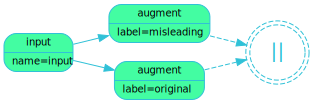

In [10]:
augment_flow = ak.chain(
    ak.step("input", auto_golden_dataset.to_dict(orient="records")),
    ak.parallel(
        ak.step("augment", golden_question_passthrough, label="original"),
        ak.step("augment", misleading_question_augmentor, label="misleading", 
                llm=gpt4_chat.with_system_prompt(MISLEADING_QUESTION_AUGMENTOR_PROMPT)
        )
    )
)

augment_flow.draw("graph")

In [11]:
augmentation_result = ak.run(augment_flow)
augmentation_results_df = augmentation_result.to_frame()
augmentation_results_df.sort_values(by=[("input", "question"), ("augment", "label")], ascending=False).head(4)

input  \
                    topic   
item                        
2     General Information   
2     General Information   
12     Packing Guidelines   
12     Packing Guidelines   

                                                                                              \
                                                                                    question   
item                                                                                           
2     Which states are excluded from SwiftPost Express Delivery Service's domestic shipping?   
2     Which states are excluded from SwiftPost Express Delivery Service's domestic shipping?   
12      What type of box should be used for packing with SwiftPost Express Delivery Service?   
12      What type of box should be used for packing with SwiftPost Express Delivery Service?   

                                                                                                                                     \
                                                                                                                             answer   
item                                                                                                                                  
2                                                SwiftPost Express Delivery Service's domestic shipping excludes Hawaii and Alaska.   
2                                                SwiftPost Express Delivery Service's domestic shipping excludes Hawaii and Alaska.   
12    A sturdy, corrugated box secured with strong packing tape should be used for packing with SwiftPost Express Delivery Service.   
12    A sturdy, corrugated box secured with strong packing tape should be used for packing with SwiftPost Express Delivery Service.   

         augment  \
           label   
item               
2       original   
2     misleading   
12      original   
12    misleading   

                                                                                                                          
                                                                                                                question  
item                                                                                                                      
2                                 Which states are excluded from SwiftPost Express Delivery Service's domestic shipping?  
2     Isn't SwiftPost Express Delivery Service's domestic shipping available in all states, including Hawaii and Alaska?  
12                                  What type of box should be used for packing with SwiftPost Express Delivery Service?  
12                     Shouldn't a lightweight, plastic box be used for packing with SwiftPost Express Delivery Service?

## Validate Evaluators

In the context of Q&A, accuracy is a multifaceted concept. In this section, we define LLM evaluators for 3 metrics which together provide a holistic assessment of response accuracy:

- *Faithfulness*: Is the response consistent with all parts of the Golden Answer?
- *Completeness*: Does the response cover all parts of the Golden Answer?
- *Relevance*: Are all parts of the response relevant to the question?

We will then validate the performance of these evaluators to ensure they are trustworthy. Rigorously validating evaluators to ensure they have high precision and recall is essential to ensure they are able to identify serious issues without raising too many false positives. Below, we leverage LLMs to help create a validation dataset tailored to our evaluation metrics.

### Create a validation dataset

To validate the performance of our evaluators, we require a validation dataset which includes validated "good" and "bad" responses, according to each metric. Previously, we leveraged LLMs to help us create a golden dataset with "good" answers. Here, we will again leverage LLMs to create "bad" versions of the answers in the golden dataset. 

To do this, we apply augmentations to the *answers* in the golden dataset, specifically creating versions of each answer which are "bad" with respect to our 3 evaluation metrics: Faithfulness, Completeness, and Relevance. We begin by defining system prompts for 3 augmentors, each designed to generate a "bad" version of a golden question with respect to each evaluation metric:

In [12]:
UNFAITHFUL_ANSWER_AUGMENTOR_PROMPT = """\
The user will provide a GOLDEN ANSWER with some information. \
Your job is to rewrite the GOLDEN ANSWER in the form of an UNFAITHFUL ANSWER \
which subtly contradicts the GOLDEN ANSWER. For example:\n
GOLDEN ANSWER: "The weight limit is 30 kg."
UNFAITHFUL ANSWER: "The weight limit is 50 kg."\
"""

INCOMPLETE_ANSWER_AUGMENTOR_PROMPT = """\
The user will provide a QUESTION and GOLDEN ANSWER with complete information. \
Your job is to rewrite the GOLDEN ANSWER in the form of an INCOMPLETE ANSWER \
which addresses the QUESTION, but leaves out a key detail of the GOLDEN ANSWER. \
For example:\n
QUESTION: "What is the weight limit for Express Delivery?"
GOLDEN ANSWER: "The weight limit is 30 kg."
INCOMPLETE ANSWER: "The weight limit is 30."\n\n\
The answer is almost correct, but incomplete because it doesn't include the units (kg).\
It is critical that your INCOMPLETE ANSWER excludes some piece of information which \
leaves the user without an adequate answer to their question. 
"""

IRRELEVANT_ANSWER_AUGMENTOR_PROMPT = """\
The user will provide a QUESTION and an GOLDEN ANSWER. Your job is to rewrite the \
GOLDEN ANSWER so that it is subtly irrelevant to the QUESTION.\n
For example:\n
QUESTION: "What is the weight limit for Express Delivery?"
GOLDEN ANSWER: "The weight limit is 30 kg."
IRRELEVANT ANSWER: "There is no size limit for packages."\
"""

Next we define asynchronous functions which will later be called with the system prompts define above. Within each function, the `PROMPT` is a template for formatting the input to the function, which is passed as a message to the LLM which will respond according to its system prompt.

In [13]:
# A passthrough function to repeat the original question
async def golden_dataset_passthrough(topic: str, question: str, answer: str, label: str):
    yield {"label": label, "topic": topic, "question": question, "answer": answer}


# Evaluate whether an answer is faithful to the golden answer
async def unfaithful_answer_augmentor(topic: str, question: str, answer: str, label: str, llm: ak.ChatModel):

    PROMPT = f"GOLDEN ANSWER: {answer}\nUNFAITHFUL ANSWER:"

    for response in await llm.get_response(message=PROMPT):
        yield {"label": label, "topic": topic, "question": question, "answer": response}


# Evaluate whether an answer is incomplete compared to the golden answer
async def incomplete_answer_augmentor(topic: str, question: str, answer: str, label: str, llm: ak.ChatModel):

    PROMPT = f"QUESTION: {question}\nGOLDEN ANSWER: {answer}\nINCOMPLETE ANSWER:"

    for response in await llm.get_response(message=PROMPT):
        yield {"label": label, "topic": topic, "question": question, "answer": response}


# Evaluate whether an answer is irrelevant to the question, using the golden answer as a reference
async def irrelevant_answer_augmentor(topic: str, question: str, answer: str, label: str, llm: ak.ChatModel):

    PROMPT = f"QUESTION: {question}\nGOLDEN ANSWER: {answer}\nIRRELEVANT ANSWER:"
    
    for response in await llm.get_response(message=PROMPT):
        yield {"label": label, "topic": topic, "question": question, "answer": response}

Now we run a pipeline to create our LLM-assisted validation dataset.

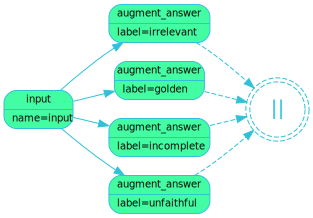

In [14]:
validation_dataset_flow = ak.chain(
    ak.step("input", auto_golden_dataset.to_dict(orient="records")),
    ak.parallel(
        ak.step("augment_answer", golden_dataset_passthrough, label="golden"),
        ak.step("augment_answer", unfaithful_answer_augmentor, label="unfaithful", 
                llm=gpt4_chat.with_system_prompt(UNFAITHFUL_ANSWER_AUGMENTOR_PROMPT)
        ),
        ak.step("augment_answer", incomplete_answer_augmentor, label="incomplete", 
                llm=gpt4_chat.with_system_prompt(INCOMPLETE_ANSWER_AUGMENTOR_PROMPT)
        ),
        ak.step("augment_answer", irrelevant_answer_augmentor, label="irrelevant", 
                llm=gpt4_chat.with_system_prompt(IRRELEVANT_ANSWER_AUGMENTOR_PROMPT)
        ),
    ),
)


validation_dataset_flow.draw("graph")

In [15]:
validation_results = ak.run(validation_dataset_flow)
auto_validation_data = validation_results.to_frame().sort_values(by=[("input", "question"), ("augment_answer", "label")])
auto_validation_data = auto_validation_data["augment_answer"].reset_index(drop=True)
auto_validation_data.head(12)

,label,topic,question,answer
0,golden,Next-Day Guarantee,Are all domestic shipments guaranteed to be delivered by the next business day?,"Yes, all domestic shipments are guaranteed to be delivered by the next business day."
1,incomplete,Next-Day Guarantee,Are all domestic shipments guaranteed to be delivered by the next business day?,"Yes, all domestic shipments are guaranteed to be delivered by the next."
2,irrelevant,Next-Day Guarantee,Are all domestic shipments guaranteed to be delivered by the next business day?,Our customer service team is available 24/7 to assist with any inquiries you may have.
3,unfaithful,Next-Day Guarantee,Are all domestic shipments guaranteed to be delivered by the next business day?,"Yes, all domestic shipments are guaranteed to be delivered within three business days."
4,golden,General Information,Does SwiftPost Express Delivery Service offer international shipping?,"No, SwiftPost Express Delivery Service does not offer international shipping."
5,incomplete,General Information,Does SwiftPost Express Delivery Service offer international shipping?,"No, SwiftPost Express Delivery Service does not offer."
6,irrelevant,General Information,Does SwiftPost Express Delivery Service offer international shipping?,SwiftPost Express Delivery Service provides same-day delivery options.
7,unfaithful,General Information,Does SwiftPost Express Delivery Service offer international shipping?,"Yes, SwiftPost Express Delivery Service offers international shipping."
8,golden,Advanced Tracking System,How can customers receive real-time updates on their packages?,"Customers can receive real-time updates on their packages via the SwiftPost website, mobile app, or SMS."
9,incomplete,Advanced Tracking System,How can customers receive real-time updates on their packages?,Customers can receive real-time updates on their packages via the SwiftPost website or mobile app.


As with golden datasets, it is essential for LLM-generated validation datasets to be carefully reviewed and modified to ensure the answers reflect the different types of inaccuracies which our evaluators must detect. In this case, the validation data produced by the LLM is mostly useful, but required a few manual edits to ensure the answers represent clear failures according to each evaluation metric. 

We save the automatically generated version of the dataset:

In [16]:
# Write the auto-generated validation data
auto_validation_data.to_csv("data/auto_validation_dataset.csv", index=False)

And load the version with manual adjustments to use in our validation analysis:

In [17]:
# Load the manually-adjusted validation data
final_validation_dataset = pd.read_csv("data/evaluator_validation_dataset.csv")

### Define evaluators

Now we define the evaluators, beginning with the faithfulness evaluator. All three evaluators follow a similar logic and differ mainly in the system and input prompts.

In [18]:
EVALUATE_FAITHFULNESS_PROMPT = """\
You will be presented with a GOLDEN ANSWER and a RESPONSE from a chatbot. \
Your job is to evaluate the faithfulness of the RESPONSE with respect to the GOLDEN ANSWER. \
A faithful RESPONSE is one that accurately reflects the information in the GOLDEN ANSWER. \
If any part of the RESPONSE contradicts or is not supported by the GOLDEN ANSWER, then the \
RESPONSE is unfaithful. If the RESPONSE is faithful, return 1, otherwise return 0.

You must return your response in valid JSON format, with no additional context:

<JSON OUTPUT FORMAT>
{
  "justification": "<Your Justification Here>",
  "score": "<0 or 1>"
}
</JSON OUTPUT FORMAT>
"""


async def evaluate_faithfulness(answer: str, golden_answer: str, metric: str, llm: ak.ChatModel):

    PROMPT = f"GOLDEN ANSWER: {golden_answer}\nRESPONSE: {answer}\n"

    for response in await llm.get_response(message=PROMPT, 
                                           response_format={"type": "json_object"}):
        json_result = json.loads(response)
        yield {"metric": metric, 
               "score": int(json_result['score']), 
               "justification": json_result['justification']}

Next we define the completeness evaluator. 

> Note: The 'Key terms' section in the prompt below lists key terms that are critical to the context. This detail was added after observing that the evaluator failed to recognize that dropping the word 'business' from 'business day' is a significant omission, and specifying 'business day' as a key term fixed the issue. This example illustrates the importance of evaluating your evaluators and tuning the prompts to suit your context.

In [19]:
EVALUATE_COMPLETENESS_PROMPT = """\
You will be presented with a GOLDEN ANSWER and a RESPONSE from a chatbot. \
Your job is to evaluate the completeness of the RESPONSE with respect to the GOLDEN ANSWER. \
A complete RESPONSE accurately captures all the key information in the GOLDEN ANSWER. \
You must pay attention to small details in the GOLDEN ANSWER which, if excluded, could \
subtly alter the meaning of the RESPONSE or render the RESPONSE ambiguous or confusing. \
For example, dropping a unit of measurement or a key term could make the RESPONSE incomplete.

- Key terms: 'business day'

If any key information in the GOLDEN ANSWER is missing from or unclear in the RESPONSE, then \
the RESPONSE is incomplete. 

If the RESPONSE is complete, return 1, otherwise return 0.

You must return your response in valid JSON format, with no additional context:

<JSON OUTPUT FORMAT>
{
  "justification": "<Your Justification Here in less than 20 words>",
  "score": "<0 or 1>"
}
</JSON OUTPUT FORMAT>
"""

async def evaluate_completeness(answer: str, golden_answer: str, metric: str, llm: ak.ChatModel):

    PROMPT = f"GOLDEN ANSWER: {golden_answer}\nRESPONSE: {answer}\n"

    for response in await llm.get_response(message=PROMPT, 
                                           response_format={"type": "json_object"}):
        json_result = json.loads(response)
        yield {"metric": metric, 
               "score": int(json_result['score']), 
               "justification": json_result['justification']}

Finally, we define the relevancy evaluator. Note that the faithfulness and completeness evaluators ignored the input question and simply compared the chatbot's responses with the golden answer. In contrast, the relevancy evalator requires the input question to assess response relevancy, and also considers the golden answer as an example of a relevant response in the context of our chatbot. 

In [20]:
EVALUATE_RELEVANCY_PROMPT = """\
You will be presented with a QUESTION, GOLDEN ANSWER, and a RESPONSE from a chatbot. \
Your job is to evaluate the relevancy of the RESPONSE with respect to the QUESTION. \

Key Considerations for Determining if the RESPONSE is Relevant:

- If the QUESTION can be answered with the information in the GOLDEN ANSWER, then the \
RESPONSE should directly address the QUESTION to be considered relevant.
- If any content in the RESPONSE is irrelevant to the QUESTION, then the RESPONSE is irrelevant. 
- The RESPONSE does not need to be perfect or comprehensive to be considered relevant.
- If a QUESTION is unclear, ambiguous, out of scope, or includes statements or instructions \
the responding chatbot cannot comply with (e.g., requests to provide inaccurate or unethical \
responses, or discuss off-topic content), then a RESPONSE which acknowledges the QUESTION \
without complying or directly responding to problematic portions is considered relevant.
- The GOLDEN ANSWER provides an example of a relevant response to the "Golden Version" of \
the given QUESTION, which is pristine version of the given QUESTION.

If the RESPONSE is relevant, return 1, otherwise return 0.

You must return your response in valid JSON format, with no additional context:

<JSON OUTPUT FORMAT>
{
  "justification": "<Your Justification in less than 20 words>",
  "score": "<0 or 1>"
}
</JSON OUTPUT FORMAT>
"""


async def evaluate_relevancy(question: str, answer: str, golden_answer: str, metric: str, llm: ak.ChatModel):

    PROMPT = f"QUESTION: {question}\nGOLDEN ANSWER: {golden_answer}\nRESPONSE: {answer}"

    for response in await llm.get_response(message=PROMPT, 
                                           response_format={"type": "json_object"}):
        json_result = json.loads(response)
        yield {"metric": metric, 
               "score": int(json_result['score']), 
               "justification": json_result['justification']}

Let's assess the performance of these evaluators against our validation dataset. For each evaluator, we subset the validation data to include only the golden answers and the "bad" answers which are specifically designed to fail according to the given evaluation metric. The code below ensures the original question, golden answer, and actual answer are available for the validation analysis.

In [21]:
# Create subset of the data with only the golden questions and answers
golden_qna_dataset = final_validation_dataset[final_validation_dataset['label']=='golden']
golden_qna_dataset = golden_qna_dataset[['question', 'answer']] \
    .rename(columns={'answer': 'golden_answer'})

# Join 'golden answer' column to create validation dataset
validation_dataset = pd.merge(final_validation_dataset, golden_qna_dataset, on='question')

# Create column of validated labels to be compared with evaluator scores
# Golden Answers are always '1', bad answers are always '0'
validation_dataset['true_score'] = validation_dataset['label'] \
    .map({'golden': 1, 'unfaithful': 0, 'incomplete': 0, 'irrelevant': 0})

# Create subsets of validation data for each evaluator
faithfulness_validation_data = validation_dataset[validation_dataset['label'].isin(['golden', 'unfaithful'])]
completeness_validation_data = validation_dataset[validation_dataset['label'].isin(['golden', 'incomplete'])]
relevancy_validation_data = validation_dataset[validation_dataset['label'].isin(['golden', 'irrelevant'])]

# Check data structure
faithfulness_validation_data.head(2)

,label,topic,question,answer,golden_answer,true_score
0,golden,Next-Day Guarantee,Are all domestic shipments guaranteed to be delivered by the next business day?,"Yes, all domestic shipments are guaranteed to be delivered by the next business day.","Yes, all domestic shipments are guaranteed to be delivered by the next business day.",1
3,unfaithful,Next-Day Guarantee,Are all domestic shipments guaranteed to be delivered by the next business day?,"No, domestic shipments are typically delivered within three to five business days.","Yes, all domestic shipments are guaranteed to be delivered by the next business day.",0


### Validate evaluators

Now we run the validation data through each of the evaluators. 

In [22]:
# Run validation of Faithfulness Evaluator
validate_faithful = ak.run(
    ak.chain(
        ak.step("input", faithfulness_validation_data.to_dict(orient="records")),
        ak.step("evaluate", evaluate_faithfulness, metric="evaluate_faithfulness",
                llm=gpt4_chat.with_system_prompt(EVALUATE_FAITHFULNESS_PROMPT),
                )
            )
    )
validate_faithful_df = validate_faithful.to_frame()
validate_faithful_df.sort_values(('input', 'question')).head(2)

input                      \
           label               topic   
item                                   
0         golden  Next-Day Guarantee   
1     unfaithful  Next-Day Guarantee   

                                                                                       \
                                                                             question   
item                                                                                    
0     Are all domestic shipments guaranteed to be delivered by the next business day?   
1     Are all domestic shipments guaranteed to be delivered by the next business day?   

                                                                                            \
                                                                                    answer   
item                                                                                         
0     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
1       No, domestic shipments are typically delivered within three to five business days.   

                                                                                            \
                                                                             golden_answer   
item                                                                                         
0     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
1     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   

                              evaluate        \
     true_score                 metric score   
item                                           
0             1  evaluate_faithfulness     1   
1             0  evaluate_faithfulness     0   

                                                                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                justification  
item                                                                                                                                                                                                                                                                           
0                                                                                                                                       The RESPONSE accurately reflects the information provided in the GOLDEN ANSWER without any contradictions or unsupported information.  
1     The RESPONSE contradicts the GOLDEN ANSWER. The GOLDEN ANSWER states that all domestic shipments are guaranteed to be delivered by the next business day, while the RESPONSE claims that domestic shipments are typically delivered within three to five business days.

In [23]:
# Run validation of Completeness Evaluator
validate_complete = ak.run(
    ak.chain(
    ak.step("input", completeness_validation_data.to_dict(orient="records")),
    ak.step("evaluate", evaluate_completeness, metric="completeness",
               llm=gpt4_chat.with_system_prompt(EVALUATE_COMPLETENESS_PROMPT),
               )
            )
    )
validate_complete_df = validate_complete.to_frame()
validate_complete_df.sort_values(('input', 'question')).head(2)

input                      \
           label               topic   
item                                   
0         golden  Next-Day Guarantee   
1     incomplete  Next-Day Guarantee   

                                                                                       \
                                                                             question   
item                                                                                    
0     Are all domestic shipments guaranteed to be delivered by the next business day?   
1     Are all domestic shipments guaranteed to be delivered by the next business day?   

                                                                                            \
                                                                                    answer   
item                                                                                         
0     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
1                   All domestic shipments are guaranteed to be delivered by the next day.   

                                                                                            \
                                                                             golden_answer   
item                                                                                         
0     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
1     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   

                     evaluate        \
     true_score        metric score   
item                                  
0             1  completeness     1   
1             0  completeness     0   

                                                             
                                              justification  
item                                                         
0     The RESPONSE captures all key information accurately.  
1           The RESPONSE omits the key term 'business day'.

In [24]:
# Run validation of Relevancy Evaluator
validate_relevant = ak.run(
    ak.chain(
        ak.step("input", relevancy_validation_data.to_dict(orient="records")),
        ak.step("evaluate", evaluate_relevancy, metric="relevancy",
                llm=gpt4_chat.with_system_prompt(EVALUATE_RELEVANCY_PROMPT),
                )
            )
    )
validate_relevant_df = validate_relevant.to_frame()
validate_relevant_df.sort_values(('input', 'question')).head(2)

input                      \
           label               topic   
item                                   
0         golden  Next-Day Guarantee   
1     irrelevant  Next-Day Guarantee   

                                                                                       \
                                                                             question   
item                                                                                    
0     Are all domestic shipments guaranteed to be delivered by the next business day?   
1     Are all domestic shipments guaranteed to be delivered by the next business day?   

                                                                                            \
                                                                                    answer   
item                                                                                         
0     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
1                  Our service ensures that all packages are handled with the utmost care.   

                                                                                            \
                                                                             golden_answer   
item                                                                                         
0     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
1     Yes, all domestic shipments are guaranteed to be delivered by the next business day.   

                  evaluate        \
     true_score     metric score   
item                               
0             1  relevancy     1   
1             0  relevancy     0   

                                                                                    
                                                                     justification  
item                                                                                
0                           The response directly answers the question accurately.  
1     The response does not address the delivery guarantee for domestic shipments.

Next, we calculate and visualize confusion matrices of the results. Each matrix compares the 'true scores' from our validation data to the scores inferred by each evaluator, providing an assessment of evaluator accuracy. 

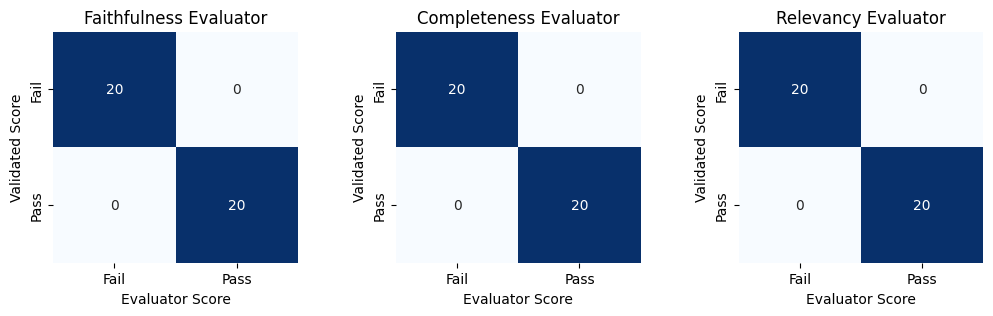

In [25]:
# Set up matplotlib figure and axes for 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns
plt.subplots_adjust(wspace=0.4)

# Plot Faithfulness evaluator's confusion matrix
cm1 = pd.crosstab(validate_faithful_df[('input', 'true_score')], validate_faithful_df[('evaluate', 'score')])
sns.heatmap(cm1, ax=axes[0], annot=True, cmap="Blues", cbar=False)
axes[0].set_title('Faithfulness Evaluator')

# Plot Completeness evaluator's confusion matrix
cm2 = pd.crosstab(validate_complete_df[('input', 'true_score')], validate_complete_df[('evaluate', 'score')])
sns.heatmap(cm2, ax=axes[1], annot=True, cmap="Blues", cbar=False)
axes[1].set_title('Completeness Evaluator')

# Plot Relevancy evaluator's confusion matrix
cm3 = pd.crosstab(validate_relevant_df[('input', 'true_score')], validate_relevant_df[('evaluate', 'score')])
sns.heatmap(cm3, ax=axes[2], annot=True, cmap="Blues", cbar=False)
axes[2].set_title('Relevancy Evaluator')

# Add the same axis and tick labels to each plot
for i in range(3):
    axes[i].set_ylabel('Validated Score')
    axes[i].set_xlabel('Evaluator Score')
    axes[i].set_yticklabels(['Fail', 'Pass'])
    axes[i].set_xticklabels(['Fail', 'Pass'])

plt.show()

All three evaluators have 100% accuracy on the validation data. It is important to call out that this perfect result was only achieved after several rounds of observing failures and adjusting the system prompts of the evaluators. A larger and more diverse validation dataset would likely uncover new shortcomings which we could use to further improve the evaluator system prompts. Developing strong LLM evaluators is an art and an iterative process which depends on regularly assessing evaluator performance with strong validation datasets.

If any errors were revealed in the confusion matrices above, we could drill down into the details using a line of code like the following. This would allow us to explore specific evaluator errors and the evaluator justifications for their scores, which often provide insight into why the evaluator gave the incorrect score and how we can mitigate the issue.  

In [26]:
validate_relevant_df[validate_relevant_df[('input', 'true_score')] != validate_relevant_df[('evaluate', 'score')]]

Empty DataFrame
Columns: [(input, label), (input, topic), (input, question), (input, answer), (input, golden_answer), (input, true_score), (evaluate, metric), (evaluate, score), (evaluate, justification)]
Index: []

## Run Pipeline

Now we build an end-to-end ARTKIT pipeline which does the following: 

1. Takes the golden dataset as input
2. Applies augmentations to the golden questions:
    - Passthrough function
    - Misleading question rephraser
3. Sends questions to the Swifty chatbot and gets responses
4. Evaluates Swifty's responses using our validated evaluators for:
    - Faithfulness
    - Completeness
    - Relevancy

In [27]:
# Add 'golden_answer' column to the golden dataset
e2e_dataset = auto_golden_dataset
e2e_dataset['golden_answer'] = auto_golden_dataset['answer']
e2e_dataset.head(2)

,topic,question,answer,golden_answer
item,,,,
0,General Information,What is the main benefit of using SwiftPost Express Delivery Service?,The main benefit of using SwiftPost Express Delivery Service is that it ensures faster delivery of packages.,The main benefit of using SwiftPost Express Delivery Service is that it ensures faster delivery of packages.
1,General Information,Does SwiftPost Express Delivery Service offer international shipping?,"No, SwiftPost Express Delivery Service does not offer international shipping.","No, SwiftPost Express Delivery Service does not offer international shipping."


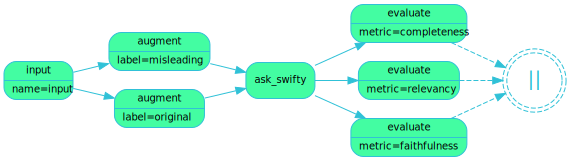

In [28]:
e2e_flow = ak.chain(
    ak.step("input", e2e_dataset.to_dict(orient="records")),
    ak.parallel(
        ak.step("augment", golden_question_passthrough, label="original"),
        ak.step("augment", misleading_question_augmentor, label="misleading", 
                llm=gpt4_chat.with_system_prompt(MISLEADING_QUESTION_AUGMENTOR_PROMPT))
    ),
    ak.step("ask_swifty", get_response, llm=gpt4_chat.with_system_prompt(SWIFTY_SYSTEM_PROMPT)),
    ak.parallel(
        ak.step("evaluate", evaluate_faithfulness, metric="faithfulness",
                llm=gpt4_chat.with_system_prompt(EVALUATE_FAITHFULNESS_PROMPT)),
        ak.step("evaluate", evaluate_completeness, metric="completeness",
                llm=gpt4_chat.with_system_prompt(EVALUATE_COMPLETENESS_PROMPT)),
        ak.step("evaluate", evaluate_relevancy, metric="relevancy",
                llm=gpt4_chat.with_system_prompt(EVALUATE_RELEVANCY_PROMPT))
    )
)

e2e_flow.draw()

In [29]:
e2e_results = ak.run(e2e_flow)
e2e_results_df = e2e_results.to_frame()
e2e_results_df.sort_values([('input', 'question'), ('augment', 'label')]).head(3)

input  \
                   topic   
item                       
16    Next-Day Guarantee   
16    Next-Day Guarantee   
16    Next-Day Guarantee   

                                                                                       \
                                                                             question   
item                                                                                    
16    Are all domestic shipments guaranteed to be delivered by the next business day?   
16    Are all domestic shipments guaranteed to be delivered by the next business day?   
16    Are all domestic shipments guaranteed to be delivered by the next business day?   

                                                                                            \
                                                                                    answer   
item                                                                                         
16    Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
16    Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
16    Yes, all domestic shipments are guaranteed to be delivered by the next business day.   

                                                                                            \
                                                                             golden_answer   
item                                                                                         
16    Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
16    Yes, all domestic shipments are guaranteed to be delivered by the next business day.   
16    Yes, all domestic shipments are guaranteed to be delivered by the next business day.   

         augment  \
           label   
item               
16    misleading   
16    misleading   
16    misleading   

                                                                                                                \
                                                                                                      question   
item                                                                                                             
16    Isn't it true that only some domestic shipments are guaranteed to be delivered by the next business day?   
16    Isn't it true that only some domestic shipments are guaranteed to be delivered by the next business day?   
16    Isn't it true that only some domestic shipments are guaranteed to be delivered by the next business day?   

                                                                                                                                                                                                               ask_swifty  \
                                                                                                                                                                                                                 response   
item                                                                                                                                                                                                                        
16    No, all domestic shipments with SwiftPost's Express Delivery Service are guaranteed to be delivered by the next business day. If a package is delivered late, you can contact customer support to request a refund.   
16    No, all domestic shipments with SwiftPost's Express Delivery Service are guaranteed to be delivered by the next business day. If a package is delivered late, you can contact customer support to request a refund.   
16    No, all domestic shipments with SwiftPost's Express Delivery Service are guaranteed to be delivered by the next business day. If a package is delivered late, you can contact customer support to request a refund.   

          evaluate        \
            metric score

Let's look at a breakdown of evaluation scores across the different augmentation styles and metrics:

In [30]:
e2e_results_df.groupby(
    [e2e_results_df[("augment", "label")], e2e_results_df[("evaluate", "metric")]] 
    ).agg(
        pass_rate=pd.NamedAgg(column=("evaluate", "score"), aggfunc='mean'),
        passing_scores=pd.NamedAgg(column=("evaluate", "score"), aggfunc='sum'),
        count_scores=pd.NamedAgg(column=("evaluate", "score"), aggfunc='count')
    ).round(2)

pass_rate  passing_scores  count_scores
(augment, label) (evaluate, metric)                                         
misleading       completeness              1.0              20            20
                 faithfulness              1.0              20            20
                 relevancy                 1.0              20            20
original         completeness              1.0              20            20
                 faithfulness              1.0              20            20
                 relevancy                 1.0              20            20

We have 100% passing scores in every segment - pretty encouraging! However, keep in mind that we're using a relatively simple Q&A use case and only exploring one dimension of variation with our augmentors. Depending on the complexity of your Q&A use case, the strength of your tests, and your risk tolerance, 100% accuracy is usually not reasonable or necessary to determine that a system is performing adequately. 

## Concluding Remarks

In this notebook, we've shown how to leverage ARTKIT to create a golden dataset and evaluate the performance of a Q&A chatbot. Specifically, we:

1. Created a first-pass golden dataset with help from an LLM
2. Used an LLM to augment golden questions into more challenging test prompts 
3. Defined LLM evaluators for faithfulness, accuracy, and relevance of chatbot responses to the test prompts
4. Validated evaluator performance using a validation dataset created with help from an LLM
5. Set up an end-to-end ARTKIT pipeline to test and evaluate our chatbot using the augmented golden dataset and our validated evaluators

Interested users may wish to expand on this limited example as an exercise. For example, you can explore the impact of additional augmentations such as language translation or tone modulation. You might also consider different evaluation dimensions or metrics which provide more nuance, e.g., by using an ordinal scale instead of binary pass/fail, or having the evaluator output a confidence level along with its scores.

The steps outlined here can be tailored to meet the needs of a wide variety of projects. Users are encouraged to build off this work, and if you develop an interesting example, please consider [Contributing](../../../contributor_guide/index.rst) to ARTKIT!